In [1]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import animation
from scipy.signal import savgol_filter
import ipywidgets as widgets
%matplotlib inline

In [2]:
def kmeans_elbow(data: np.ndarray, num_cluster: int,title_name:str,s:int):
    '''
    Calculates the sum of squares for different number of clusters using K-means
    This allows to select an optimal number of cluster
    '''
    sum_squares = np.zeros(len(range(2, num_cluster+1)))
    silho_coeff = np.zeros(len(range(2, num_cluster+1)))
    j=0
    for i in range(2, num_cluster+1):
        kmeans = KMeans(n_clusters=i, random_state=0).fit(data)
        if s == 0:
            print("Num cluster:", i, "Sum of squares:", kmeans.inertia_)
            sum_squares[j] = kmeans.inertia_
        elif s == 1:
            labels = kmeans.labels_
            silho_coeff[j] = metrics.silhouette_score(data,labels)
            print("For n_clusters =",i,"The average silhouette_score is :",silho_coeff[j],)
        j+=1

    plt.figure()
    # plt.plot(np.arange(2, num_cluster+1), sum_squares)
    # plt.ylabel('Sum of Squares', fontsize = 14)
    # plt.xlabel('Number of clusters', fontsize = 14)   
    # plt.title(title_name)
    plt.plot(np.arange(2, num_cluster+1), silho_coeff)
    plt.ylabel('Silhouette Coefficient', fontsize = 14)
    plt.xlabel('Number of clusters', fontsize = 14)
    plt.title(title_name)
    plt.show()

In [8]:
def Paddington(data: np.ndarray,time:np.ndarray,max_time:float,max_length:int,empty_value:float, min_data:float):
    '''
    Pads an array so data depends depends on time-series data.
    Allows for the data to represent real world time series while being the same size
    Also big fan of maramlade
    '''
    initial_time = time[0]
    final_time = time[-1]
    missing_points = max_length - time.shape[0]
    missing_time = initial_time + (max_time-final_time)
    # print('First time value:',initial_time)
    # Calculates the number of point to add to the back and front proportional to the time missing
    front_pad = int(np.rint(missing_points * initial_time / missing_time))
    back_pad  = int(np.rint(missing_points * (max_time-final_time) / missing_time))
    out_data = (data - min_data)/ (np.max(data)-min_data)
    if initial_time < 2:
        out_data = np.pad(out_data,(front_pad,0),'edge')
    else:
        out_data = np.pad(out_data,(front_pad,0),'constant', constant_values = (empty_value,0))
    if (max_time-final_time)<2:
        out_data = np.pad(out_data,(0,back_pad),'edge')
    else:
        out_data = np.pad(out_data,(0,back_pad),'constant', constant_values = (0,empty_value))

    out_time = np.pad(time,(front_pad,back_pad) ,'linear_ramp', end_values = (0,max_time) )
    return out_data,out_time

In [11]:
# Read in data and set nan's to zero
starlink_data = np.load("starlink_data.npy")
starlink_data = np.nan_to_num(starlink_data, nan = 0)
print(starlink_data.shape)

# sat_ind = np.random.choice(starlink_data.shape[0],50plt.figure(figsize=(14, 7.5), dpi=150)
sat_ind = np.arange(starlink_data.shape[0])
time_ind = 1

time = starlink_data[sat_ind, ::time_ind, 0]
time = (time - 2022*10**9) *10**-6
time = time - np.min(time[:,0:1])

angular_momentum_x = starlink_data[sat_ind, ::time_ind, 7]
angular_momentum_y = starlink_data[sat_ind, ::time_ind, 8]
angular_momentum_z = starlink_data[sat_ind, ::time_ind, 9]

angular_momentum = np.dstack([angular_momentum_x,angular_momentum_y,angular_momentum_z])
angular_momentum_mag = np.linalg.norm(angular_momentum,axis =2)

position = starlink_data[ :, ::time_ind,1:4]
radius = np.linalg.norm(position,axis =2)


#changes the added zeros in the matrix to the last value for radius, angular momentum and time
max_time = np.max(time)
l = time.shape[1]
# Earth_r = 6378**(1/2)/3
# Earth_h = 45000**(1/2)/3
Earth_r = 0
Earth_h = 0
min_ang_x = np.min(np.abs(angular_momentum_x[np.nonzero(angular_momentum_x)]))
min_ang_y = np.min(np.abs(angular_momentum_y[np.nonzero(angular_momentum_y)]))
min_ang_z = np.min(np.abs(angular_momentum_z[np.nonzero(angular_momentum_z)]))
min_radius = np.min(radius[np.nonzero(radius)])
min_position = np.min(np.abs(position[np.nonzero(position)]))
min_ang_mag = np.min(np.abs(angular_momentum_mag[np.nonzero(angular_momentum_mag)]))

for i in range(time.shape[0]):
    ind = radius[i,:]>0
    radius[i,:] = Paddington( radius[i,:][ind], time[i,:][ind], max_time, l,(3*Earth_r)**2,min_radius)[0]
    position[i,:,0] = Paddington( position[i,:,0][ind], time[i,:][ind], max_time, l,0,min_position)[0]
    position[i,:,1] = Paddington( position[i,:,1][ind], time[i,:][ind], max_time, l,0,min_position)[0]
    position[i,:,2] = Paddington( position[i,:,2][ind], time[i,:][ind], max_time, l,0,min_position)[0]
    angular_momentum_x[i,:] = Paddington( angular_momentum_x[i,:][ind], time[i,:][ind], max_time, l, Earth_h, min_ang_x)[0]
    angular_momentum_y[i,:] = Paddington( angular_momentum_y[i,:][ind], time[i,:][ind], max_time, l, Earth_h, min_ang_y)[0]
    angular_momentum_mag[i,:] = Paddington( angular_momentum_mag[i,:][ind], time[i,:][ind], max_time, l, Earth_h, min_ang_mag)[0]
    angular_momentum_z[i,:], time[i,:] = Paddington( angular_momentum_z[i,:][ind], time[i,:][ind], max_time, l,Earth_h,min_ang_z)


angular_momentum_stacked = np.concatenate([angular_momentum_x,angular_momentum_y,angular_momentum_z], axis = 1)
position_stacked = np.concatenate([position[:,:,0],position[:,:,1],position[:,:,2] ], axis = 1)

(1984, 8018, 10)


(1984, 8018)
(1984, 8018)
0


/tmp/ipykernel_1177601/912791650.py:5: RuntimeWarning: invalid value encountered in true_divide
  i = 180 /np.pi *np.arccos(angular_momentum_z[:,0]/np.sqrt(angular_momentum_x[:,0]**2+angular_momentum_y[:,0]**2+angular_momentum_z[:,0]**2))


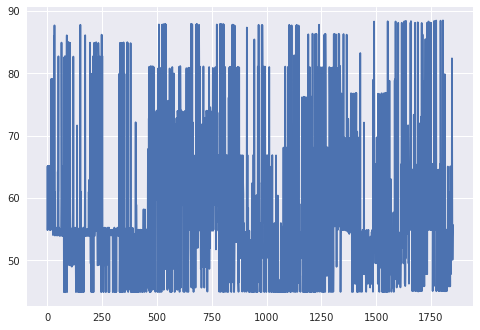

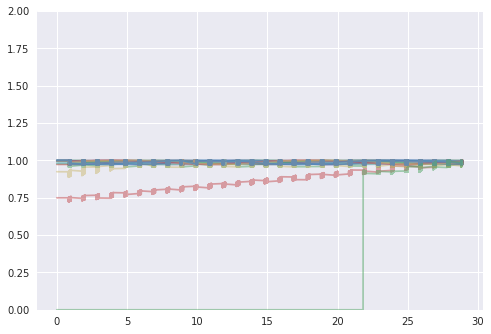

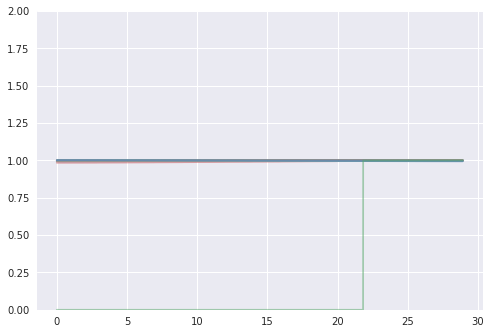

In [13]:
# check size of the data
print(time.shape)
print(angular_momentum_x.shape)
print(np.sum(time[:,0:1] > 1))
i = 180 /np.pi *np.arccos(angular_momentum_z[:,0]/np.sqrt(angular_momentum_x[:,0]**2+angular_momentum_y[:,0]**2+angular_momentum_z[:,0]**2))
plt.figure()
plt.plot(i)
plt.show()
plt.figure()
plt.style.use('seaborn')
for i in range(time[::100].shape[0]):
    plt.plot( time[::100,:][i], radius[::100,:][i], alpha = 0.5)
# plt.ylim([6650,7000])
plt.ylim([0,2])
plt.show()

plt.figure()
plt.style.use('seaborn')
min_ang = np.min(angular_momentum_mag[np.nonzero(angular_momentum_mag)])
for i in range(time[::100].shape[0]):
    plt.plot( time[::100,:][i], angular_momentum_z[::100,:][i], alpha = 0.5)
# plt.ylim([51000,53000])
plt.ylim([0,2])
plt.show()


Num cluster: 2 Sum of squares: 230662571228475.3
Num cluster: 3 Sum of squares: 225351413271311.0
Num cluster: 4 Sum of squares: 221746949113134.88
Num cluster: 5 Sum of squares: 218935802408497.38
Num cluster: 6 Sum of squares: 216180624390215.34
Num cluster: 7 Sum of squares: 214061321999261.8
Num cluster: 8 Sum of squares: 212257201776823.34
Num cluster: 9 Sum of squares: 210517909698998.72
Num cluster: 10 Sum of squares: 208988596368187.25
Num cluster: 11 Sum of squares: 207619340928544.8
Num cluster: 12 Sum of squares: 205689258223019.62
Num cluster: 13 Sum of squares: 204802702777694.3
Num cluster: 14 Sum of squares: 203810580012822.47
Num cluster: 15 Sum of squares: 202230670084529.97


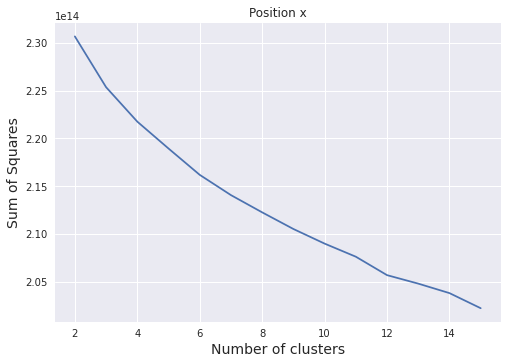

Num cluster: 2 Sum of squares: 6539832843460651.0
Num cluster: 3 Sum of squares: 4186365387491744.5
Num cluster: 4 Sum of squares: 2538873994887493.0
Num cluster: 5 Sum of squares: 1903872800218919.2
Num cluster: 6 Sum of squares: 1409716972774278.0
Num cluster: 7 Sum of squares: 1115319197858469.5
Num cluster: 8 Sum of squares: 901605571133754.4
Num cluster: 9 Sum of squares: 706164973073859.9
Num cluster: 10 Sum of squares: 583520355204026.9
Num cluster: 11 Sum of squares: 480288054192827.94
Num cluster: 12 Sum of squares: 423786773110134.4
Num cluster: 13 Sum of squares: 364901299613076.94
Num cluster: 14 Sum of squares: 319913822860225.25
Num cluster: 15 Sum of squares: 290372352784017.5


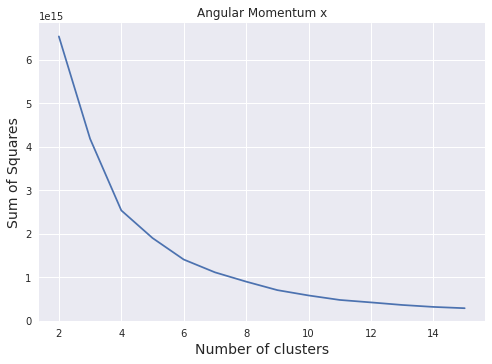

Num cluster: 2 Sum of squares: 234779344937673.53
Num cluster: 3 Sum of squares: 229282707990822.6
Num cluster: 4 Sum of squares: 225592021603307.38
Num cluster: 5 Sum of squares: 222642018366575.25
Num cluster: 6 Sum of squares: 219938226425004.38
Num cluster: 7 Sum of squares: 218137197553219.94
Num cluster: 8 Sum of squares: 216023844165828.97
Num cluster: 9 Sum of squares: 214074645666446.4
Num cluster: 10 Sum of squares: 212640877144941.03
Num cluster: 11 Sum of squares: 210732579276847.7
Num cluster: 12 Sum of squares: 209458002782734.78
Num cluster: 13 Sum of squares: 208139978034447.44
Num cluster: 14 Sum of squares: 207149087258059.8
Num cluster: 15 Sum of squares: 206033876721729.22


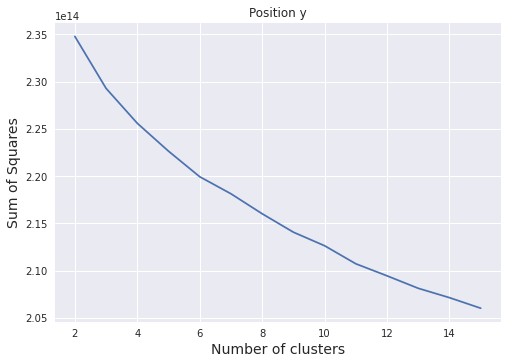

Num cluster: 2 Sum of squares: 6219967012770374.0
Num cluster: 3 Sum of squares: 4147173110547825.5
Num cluster: 4 Sum of squares: 2588530837696597.5
Num cluster: 5 Sum of squares: 1887279054283108.2
Num cluster: 6 Sum of squares: 1383061670224381.0
Num cluster: 7 Sum of squares: 1130603824366583.0
Num cluster: 8 Sum of squares: 872018666963600.8
Num cluster: 9 Sum of squares: 689169775507130.2
Num cluster: 10 Sum of squares: 563588771503628.5
Num cluster: 11 Sum of squares: 469383991456859.75
Num cluster: 12 Sum of squares: 388994473634194.75
Num cluster: 13 Sum of squares: 357433300750566.6
Num cluster: 14 Sum of squares: 324953867259934.2
Num cluster: 15 Sum of squares: 304091123197763.8


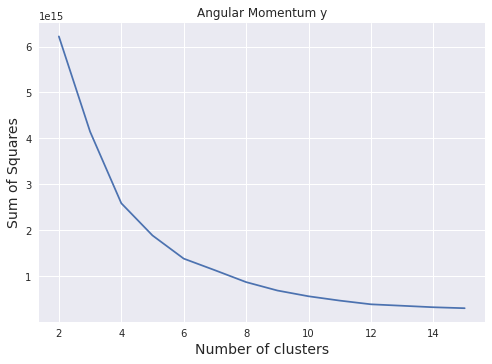

Num cluster: 2 Sum of squares: 224376197585644.12
Num cluster: 3 Sum of squares: 219039090104055.06
Num cluster: 4 Sum of squares: 215537300154861.12
Num cluster: 5 Sum of squares: 212727517858419.84
Num cluster: 6 Sum of squares: 210511755376926.94
Num cluster: 7 Sum of squares: 208280595753160.97
Num cluster: 8 Sum of squares: 205991151119155.6
Num cluster: 9 Sum of squares: 204723006844768.94
Num cluster: 10 Sum of squares: 203009264748378.34
Num cluster: 11 Sum of squares: 201573509477126.34
Num cluster: 12 Sum of squares: 200740569966826.4
Num cluster: 13 Sum of squares: 199521745715735.5
Num cluster: 14 Sum of squares: 198263688304379.5
Num cluster: 15 Sum of squares: 197219356367569.47


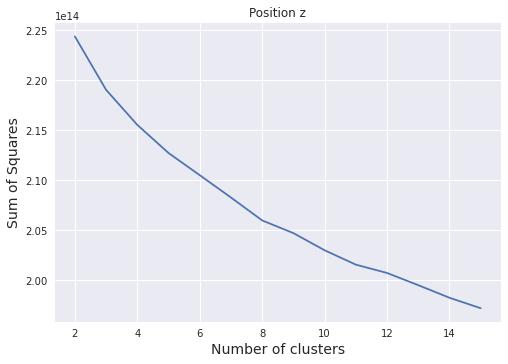

Num cluster: 2 Sum of squares: 166648506774441.28
Num cluster: 3 Sum of squares: 87204416567265.11
Num cluster: 4 Sum of squares: 50745437284093.64
Num cluster: 5 Sum of squares: 30948563488658.008
Num cluster: 6 Sum of squares: 19346310944683.73
Num cluster: 7 Sum of squares: 13859392160551.04
Num cluster: 8 Sum of squares: 9676332866539.484
Num cluster: 9 Sum of squares: 7751025558500.726
Num cluster: 10 Sum of squares: 5876774966321.85
Num cluster: 11 Sum of squares: 4803893767449.621
Num cluster: 12 Sum of squares: 3756211003653.7056
Num cluster: 13 Sum of squares: 3124914052646.5054
Num cluster: 14 Sum of squares: 2455211113874.0234
Num cluster: 15 Sum of squares: 1823914162866.822


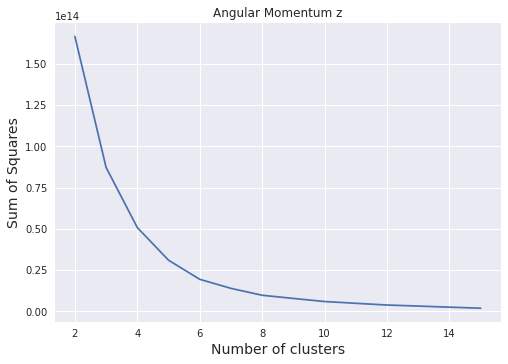

Num cluster: 2 Sum of squares: 244223959914418.84
Num cluster: 3 Sum of squares: 143173392174515.06
Num cluster: 4 Sum of squares: 86116986922343.6
Num cluster: 5 Sum of squares: 54017497891371.016
Num cluster: 6 Sum of squares: 31273675985128.39
Num cluster: 7 Sum of squares: 20909230966528.906
Num cluster: 8 Sum of squares: 15693808966899.336
Num cluster: 9 Sum of squares: 12698917559878.982
Num cluster: 10 Sum of squares: 9825333126666.715
Num cluster: 11 Sum of squares: 8063037498781.082
Num cluster: 12 Sum of squares: 6412555520807.441
Num cluster: 13 Sum of squares: 4317204595768.845
Num cluster: 14 Sum of squares: 2797539442848.3223
Num cluster: 15 Sum of squares: 2101088786989.4404


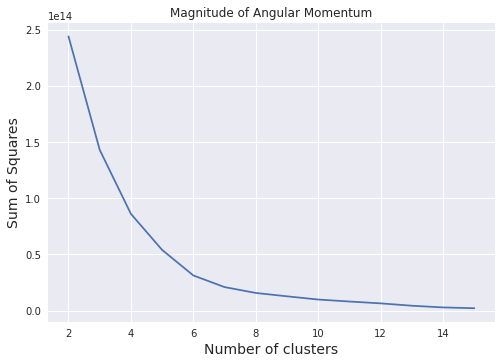

Num cluster: 2 Sum of squares: 67754923443.850876
Num cluster: 3 Sum of squares: 16517924592.181475
Num cluster: 4 Sum of squares: 12133712178.068491
Num cluster: 5 Sum of squares: 8328137861.159311
Num cluster: 6 Sum of squares: 6273765230.267561
Num cluster: 7 Sum of squares: 4724917729.938048
Num cluster: 8 Sum of squares: 3903456588.344837
Num cluster: 9 Sum of squares: 3254915957.2995596
Num cluster: 10 Sum of squares: 2621893094.734008
Num cluster: 11 Sum of squares: 2023186094.6493528
Num cluster: 12 Sum of squares: 1793544106.9335568
Num cluster: 13 Sum of squares: 1591973026.492339
Num cluster: 14 Sum of squares: 1461300749.3581743
Num cluster: 15 Sum of squares: 1368301029.4664176


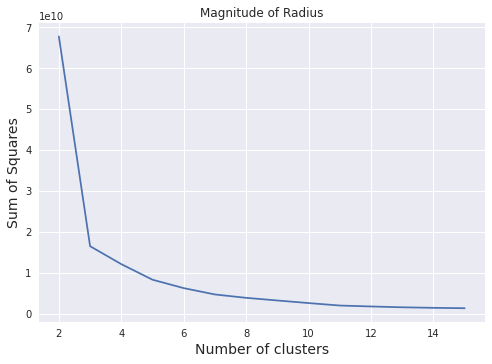

Num cluster: 2 Sum of squares: 1.6780759172673182e+16
Num cluster: 3 Sum of squares: 9794466528862358.0
Num cluster: 4 Sum of squares: 6551662653307506.0
Num cluster: 5 Sum of squares: 4965779423001581.0
Num cluster: 6 Sum of squares: 3481717434597029.0
Num cluster: 7 Sum of squares: 2609154758016347.5
Num cluster: 8 Sum of squares: 2086396755174891.5
Num cluster: 9 Sum of squares: 1659808301670766.2
Num cluster: 10 Sum of squares: 1432679912415802.2
Num cluster: 11 Sum of squares: 1236389117966583.5
Num cluster: 12 Sum of squares: 1100222778403327.1
Num cluster: 13 Sum of squares: 981286744529290.9
Num cluster: 14 Sum of squares: 849845773617881.2
Num cluster: 15 Sum of squares: 744240018793552.5


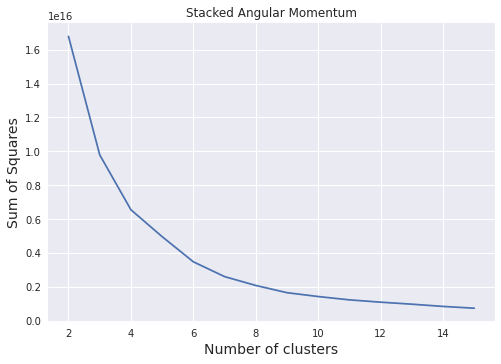

Num cluster: 2 Sum of squares: 697485111315607.6
Num cluster: 3 Sum of squares: 687023556119308.4
Num cluster: 4 Sum of squares: 679970544092603.2
Num cluster: 5 Sum of squares: 673927140450919.4
Num cluster: 6 Sum of squares: 668772211176669.9
Num cluster: 7 Sum of squares: 664053838954321.8
Num cluster: 8 Sum of squares: 658918086347803.4
Num cluster: 9 Sum of squares: 655779245864145.6
Num cluster: 10 Sum of squares: 652410539585022.9
Num cluster: 11 Sum of squares: 647099635115803.6
Num cluster: 12 Sum of squares: 645981719221242.2
Num cluster: 13 Sum of squares: 643223112517359.8
Num cluster: 14 Sum of squares: 638814973691331.8
Num cluster: 15 Sum of squares: 636636890449421.1


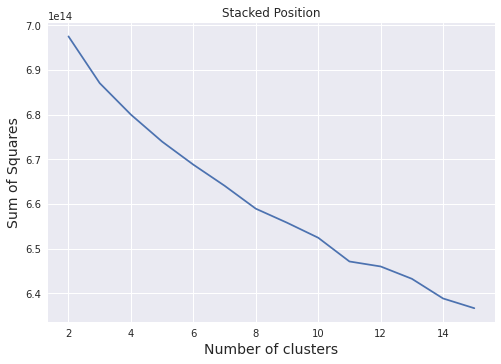

In [9]:
# Generates the k-means elbow plot to check the optimal number of clusters on Radius
num_clusters = 15


list_var = ['x','y','z']
for i in range(3):
    kmeans_elbow(position[:,:,i],num_clusters,'Position '+list_var[i],0)
    kmeans_elbow(angular_momentum[:,:,i],num_clusters,'Angular Momentum '+list_var[i],0)
kmeans_elbow(angular_momentum_mag,num_clusters, 'Magnitude of Angular Momentum',0)
kmeans_elbow(radius, num_clusters, 'Magnitude of Radius',0)

kmeans_elbow(angular_momentum_stacked,num_clusters,'Stacked Angular Momentum',0)
kmeans_elbow(position_stacked,num_clusters,'Stacked Position',0)

For n_clusters = 2 The average silhouette_score is : 0.9336939831575928
For n_clusters = 3 The average silhouette_score is : 0.9397679145473908
For n_clusters = 4 The average silhouette_score is : 0.9514162617264174
For n_clusters = 5 The average silhouette_score is : 0.9630506250259985
For n_clusters = 6 The average silhouette_score is : 0.967708422989343
For n_clusters = 7 The average silhouette_score is : 0.9700874859379873
For n_clusters = 8 The average silhouette_score is : 0.9721002193899532
For n_clusters = 9 The average silhouette_score is : 0.973063824222137
For n_clusters = 10 The average silhouette_score is : 0.9742132260485618
For n_clusters = 11 The average silhouette_score is : 0.9752438589650344
For n_clusters = 12 The average silhouette_score is : 0.9756281926383954
For n_clusters = 13 The average silhouette_score is : 0.975220461857767
For n_clusters = 14 The average silhouette_score is : 0.9764045549012568
For n_clusters = 15 The average silhouette_score is : 0.975996

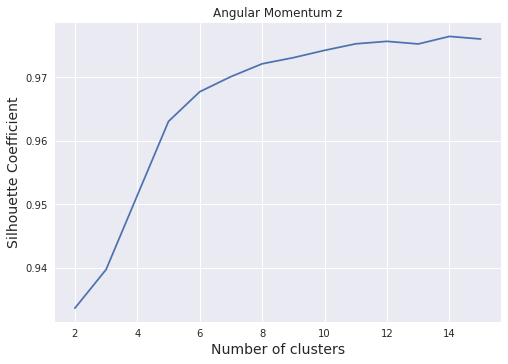

For n_clusters = 2 The average silhouette_score is : 0.9682706729371455
For n_clusters = 3 The average silhouette_score is : 0.9667129868979412
For n_clusters = 4 The average silhouette_score is : 0.9779707693510038
For n_clusters = 5 The average silhouette_score is : 0.9751258831189846
For n_clusters = 6 The average silhouette_score is : 0.9785376614887429
For n_clusters = 7 The average silhouette_score is : 0.9796297520455205
For n_clusters = 8 The average silhouette_score is : 0.9805499815703228
For n_clusters = 9 The average silhouette_score is : 0.9809856818215079
For n_clusters = 10 The average silhouette_score is : 0.9813426738072785
For n_clusters = 11 The average silhouette_score is : 0.981306264675203
For n_clusters = 12 The average silhouette_score is : 0.9813710426833043
For n_clusters = 13 The average silhouette_score is : 0.9819715345604411
For n_clusters = 14 The average silhouette_score is : 0.9821480408816489
For n_clusters = 15 The average silhouette_score is : 0.8937

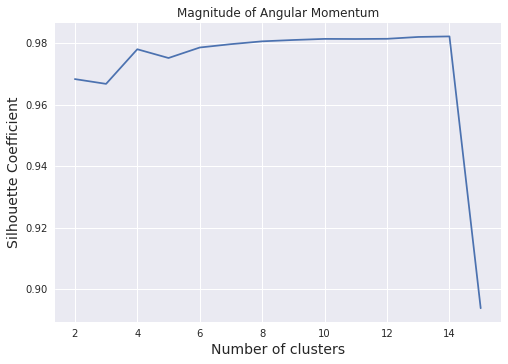

For n_clusters = 2 The average silhouette_score is : 0.8661346031235693
For n_clusters = 3 The average silhouette_score is : 0.8721082814162375
For n_clusters = 4 The average silhouette_score is : 0.8699661478465716
For n_clusters = 5 The average silhouette_score is : 0.8369910069741392
For n_clusters = 6 The average silhouette_score is : 0.8471827437512544
For n_clusters = 7 The average silhouette_score is : 0.853633035141011
For n_clusters = 8 The average silhouette_score is : 0.8538455081894744
For n_clusters = 9 The average silhouette_score is : 0.8452077515736297
For n_clusters = 10 The average silhouette_score is : 0.7888613626611555
For n_clusters = 11 The average silhouette_score is : 0.7910419514613813
For n_clusters = 12 The average silhouette_score is : 0.7953013522309422
For n_clusters = 13 The average silhouette_score is : 0.7977764345387591
For n_clusters = 14 The average silhouette_score is : 0.7982492212805579
For n_clusters = 15 The average silhouette_score is : 0.7221

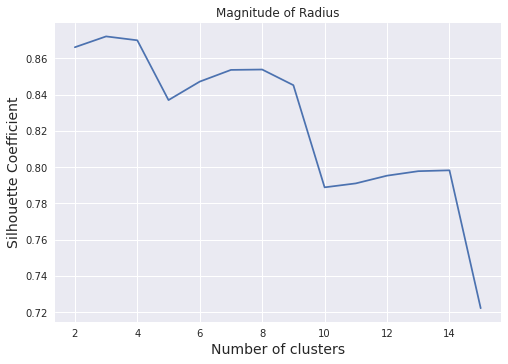

In [19]:
n = 15
kmeans_elbow(angular_momentum_z,n,'Angular Momentum z',s=1)
kmeans_elbow(angular_momentum_mag,n, 'Magnitude of Angular Momentum',s=1)
kmeans_elbow(radius, n, 'Magnitude of Radius',s=1)

In [14]:
def plot_time_clusters(cluster: np.ndarray, num_clusters: int, 
            angular_momentum_x: np.ndarray,
            angular_momentum_y: np.ndarray,
            angular_momentum_z: np.ndarray,
            time: np.ndarray, axis: int):
    '''
    plots angular momentum and their clusters as a function of time 
    '''
    fig = plt.figure(figsize= (15,15))
    fig, axs =plt.subplots(3,1, sharex= True)
    for i in range(0,num_clusters):
        title = "cluster" + str(i)
        if axis == 0:
            time_tmp = time[cluster == i]
            angular_momentum_x_tmp = angular_momentum_x[cluster == i]
            angular_momentum_y_tmp = angular_momentum_y[cluster == i]
            angular_momentum_z_tmp = angular_momentum_z[cluster == i]
            ind  = np.dstack(np.random.choice(time_tmp.shape[0],1))
        elif axis == 1:
            time_tmp = time[:,cluster == i]
            angular_momentum_x_tmp = angular_momentum_x[:,cluster == i]
            angular_momentum_y_tmp = angular_momentum_y[:,cluster == i]
            angular_momentum_z_tmp = angular_momentum_z[:,cluster == i]
            ind = 92
        axs[0].scatter(time_tmp[ind,:],angular_momentum_x_tmp[ind,:])
        axs[0].set_ylabel('h_x')
        axs[1].scatter(time_tmp[ind,:],angular_momentum_y_tmp[ind,:])
        axs[1].set_ylabel('h_y')
        axs[2].scatter(time_tmp[ind,:],angular_momentum_z_tmp[ind,:],label = title)
        axs[2].set_ylabel('h_z')
        axs[2].legend()

In [15]:
def plot_clusters_3d( time_point: int, 
    clusters: np.ndarray, num_clusters: int,           
            angular_momentum_x: np.ndarray,
            angular_momentum_y: np.ndarray,
            angular_momentum_z: np.ndarray,  axis: int):
    '''
    Plots data in 3d scatter plot. Each cluster is colored differently and labelled.
    '''
    plt.cla()
    if axis == 0:
        for i in range(0,num_clusters):
            title = "Cluster" + str(i)
            # ind  = np.arange(0,angular_momentum_x[clusters == i].shape[1],100)notebook
            ind = time_point
            ax.scatter(angular_momentum_x[clusters == i][:,ind],
                       angular_momentum_y[clusters == i][:,ind],
                       angular_momentum_z[clusters == i][:,ind], s = 20 , label = title)
    elif axis == 1:
        for i in range(0,num_clusters):
            title = "Cluster" + str(i)
            ind  = np.arange(0,angular_momentum_x[:,clusters == i].shape[0],100)
            ind = 920
            #ind = time_point
            ax.scatter(angular_momentum_x[:,clusters == i][ind],
                       angular_momentum_y[:,clusters == i][ind],
                       angular_momentum_z[:,clusters == i][ind], s = 40 , label = title)
    ax.set_xlabel('h_x')
    ax.set_ylabel('h_y')
    ax.set_zlabel('h_z')
    ax.set_xlim([-50000, 50000])
    ax.set_ylim([-50000, 50000])
    ax.set_zlim([29500, 32000])
    ax.legend()

In [28]:
def ts_cluster_plot(time: np.ndarray,
            data: np.ndarray, 
            num_cluster: int, 
            cluster_labels: np.ndarray, 
            cluster_centers: np.ndarray, 
            dimension: int,
            ylabel: str):
    '''
    Plot the time-series data and the cluster center in each cluster. 
    '''

    plt.style.use("seaborn")
    for i in range(num_cluster):
        # Plot all the clusters in a subplot
        if dimension == 1:
            plt.subplot(num_cluster//3+1, 3, i+1)
            
            for t,ts in zip(time[cluster_labels == i], data[cluster_labels == i]):
                plt.plot(t,ts, "k-", linewidth=0.1)

            plt.plot(t,cluster_centers[i, :], "r-")

            plt.title("Cluster " + str(i+1))
            plt.xlabel('Time in Days')
            plt.ylabel(ylabel)
            plt.xticks(fontsize=8)
            plt.yticks(fontsize=8)
        # Plot 1 cluster on each row of subplot with each physical quantity in a column
        else:
            for j in range(dimension):
                plt.subplot(num_cluster, dimension, i*dimension+j+1)
                
                for ts in data[cluster_labels == i][:, :, j]:
                    plt.plot(ts, "k-", linewidth=0.1)

                plt.plot(cluster_centers[i, :, j], "r-")

                plt.xticks(fontsize=8)
                plt.yticks(fontsize=8)

                if i == 0 and j == 0:
                    plt.title("Angular Momentum in x-direction", fontsize=8)
                elif i == 0 and j == 1:
                    plt.title("Angular Momentum in y-direction", fontsize=8)
                elif i == 0 and j == 2:
                    plt.title("Angular Momentum in z-direction", fontsize=8)
            plt.figtext(0.5, 1-(i*(1/num_cluster+0.01)), "Cluster " + str(i+1))

In [29]:
# Runs K-means on the optimal number of clusters determined from the elbow plot
num_clusters = 7

hx_kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(angular_momentum_x)
hy_kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(angular_momentum_y)

h_stack_kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(angular_momentum_stacked)


hx_clusters = hx_kmeans.labels_
hy_clusters = hy_kmeans.labels_

h_stack_clusters = h_stack_kmeans.labels_


In [30]:
def kmeans_optimal(time,data,optimal_cluster,dim, ylabel):
    data_kmeans= KMeans(n_clusters=optimal_cluster, random_state=0).fit(data)
    out_clusters = data_kmeans.labels_
    out_clusters_centers = data_kmeans.cluster_centers_
    print('Cluster silhouette score:',metrics.silhouette_score(data,out_clusters))

    plt.figure(figsize=(14, 7), dpi=150)
    ts_cluster_plot(time,data, 
                optimal_cluster, 
                out_clusters, 
                out_clusters_centers, 
                dim,
                ylabel)
    return out_clusters,data_kmeans

Clustering on Radius
Cluster silhouette score: 0.8315713536330551


<Figure size 2100x2250 with 0 Axes>

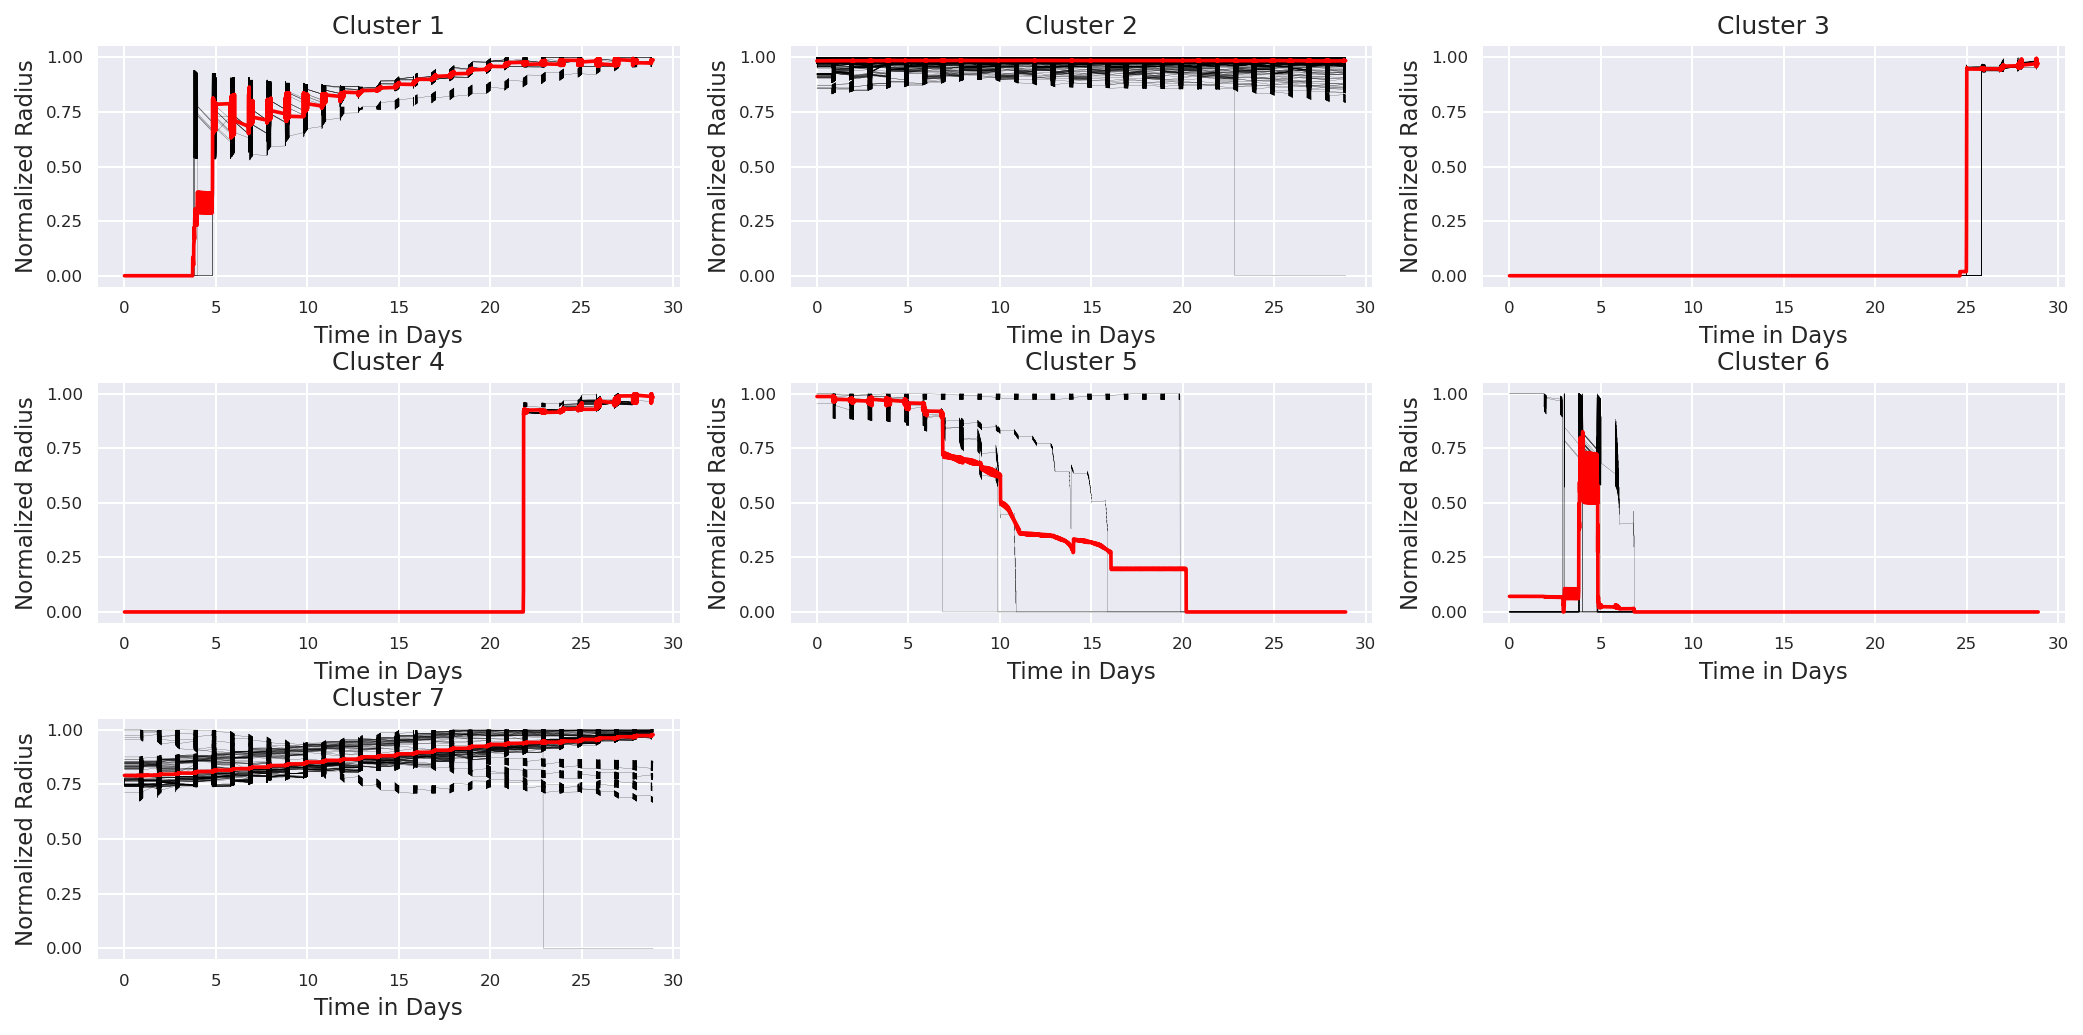

In [31]:
%matplotlib inline
plt.figure(figsize=(14, 15), dpi=150)
optimal_cluster_R = 7
print('Clustering on Radius')
r_clusters, radius_kmeans = kmeans_optimal(time,radius,optimal_cluster_R,1,'Normalized Radius')
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()


Clustering on Angular Momentum z
Cluster silhouette score: 0.9810430645506223


<Figure size 2100x2250 with 0 Axes>

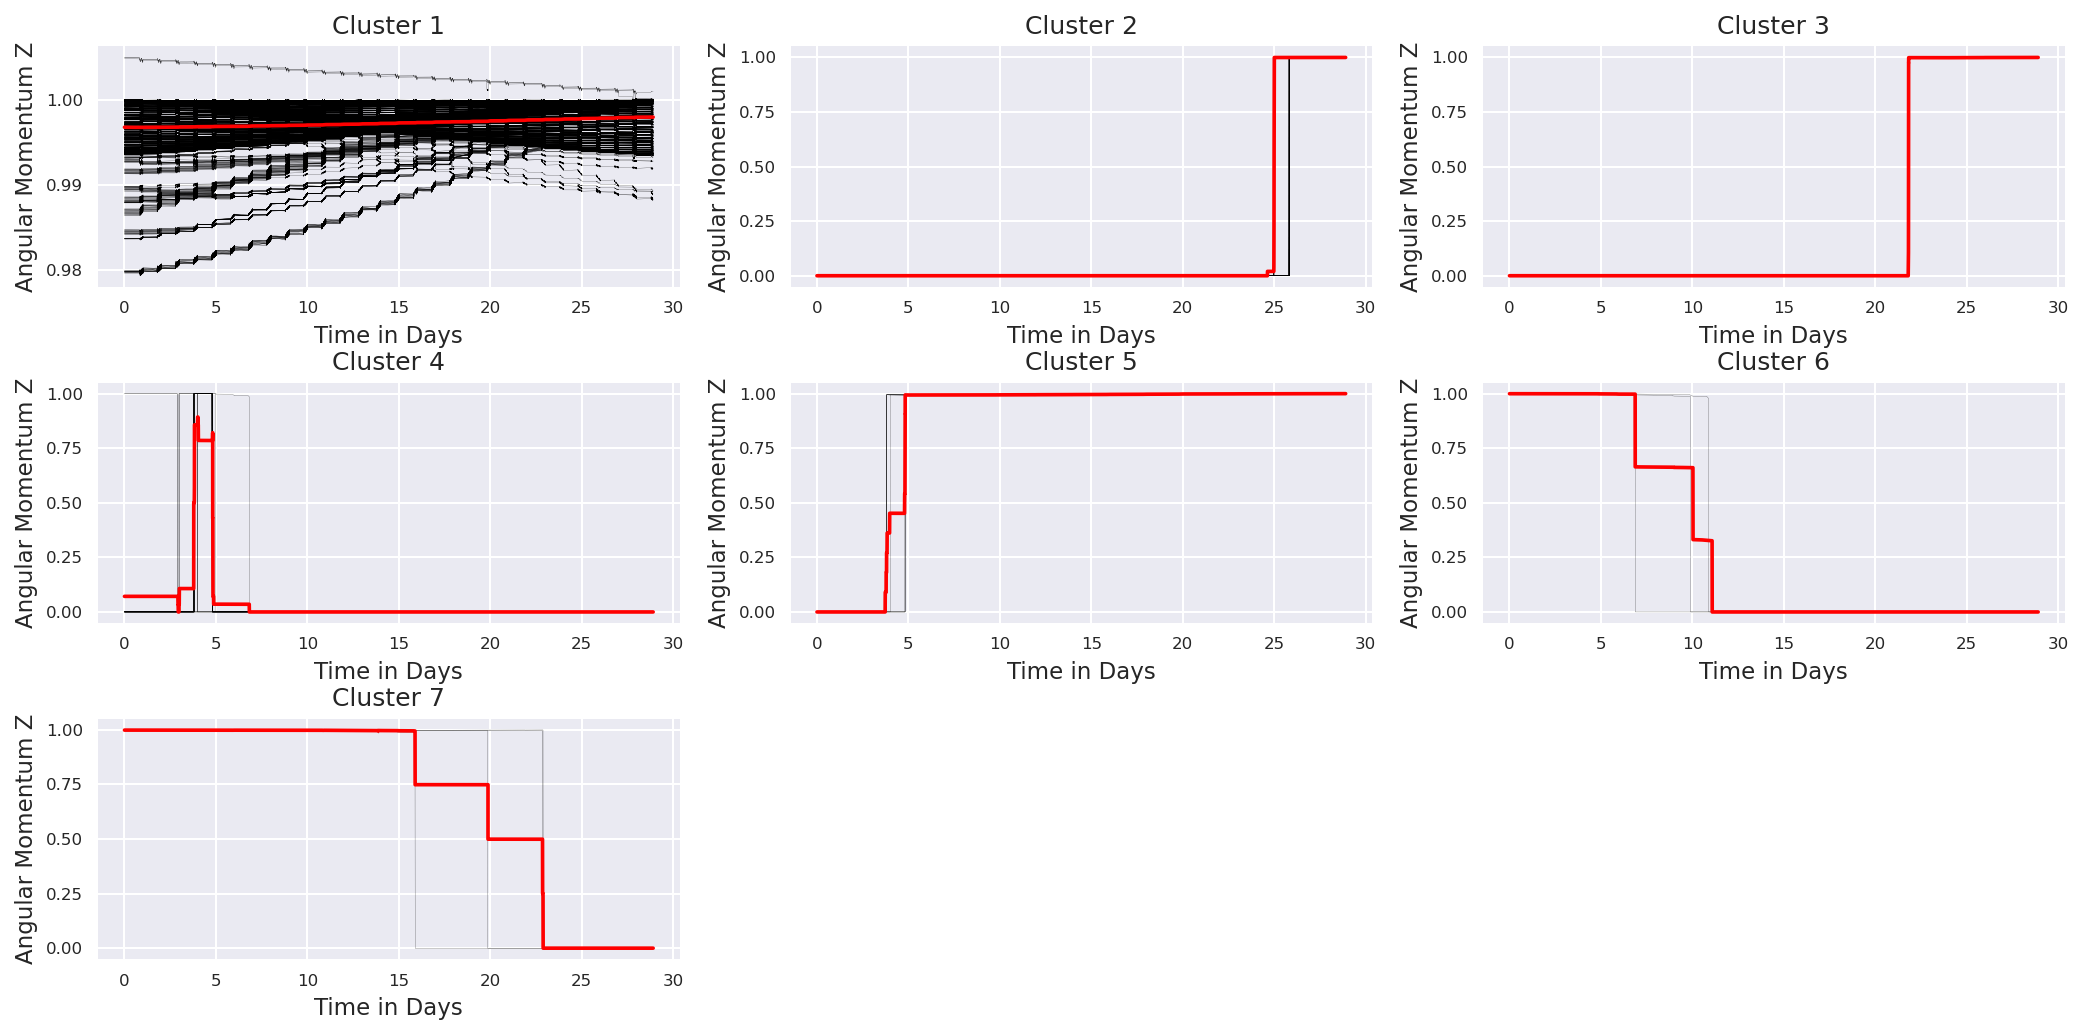

In [32]:
%matplotlib inline
plt.figure(figsize=(14, 15), dpi=150)
optimal_cluster_hz = 7
print('Clustering on Angular Momentum z')
hz_clusters,hz_kmeans = kmeans_optimal(time,angular_momentum_z,optimal_cluster_hz,1,'Angular Momentum Z')
plt.tight_layout()

plt.subplots_adjust(hspace=0.4)
plt.show()

Clustering on Angular momentum Magnitude
Cluster silhouette score: 0.8420902698853014


<Figure size 2100x2250 with 0 Axes>

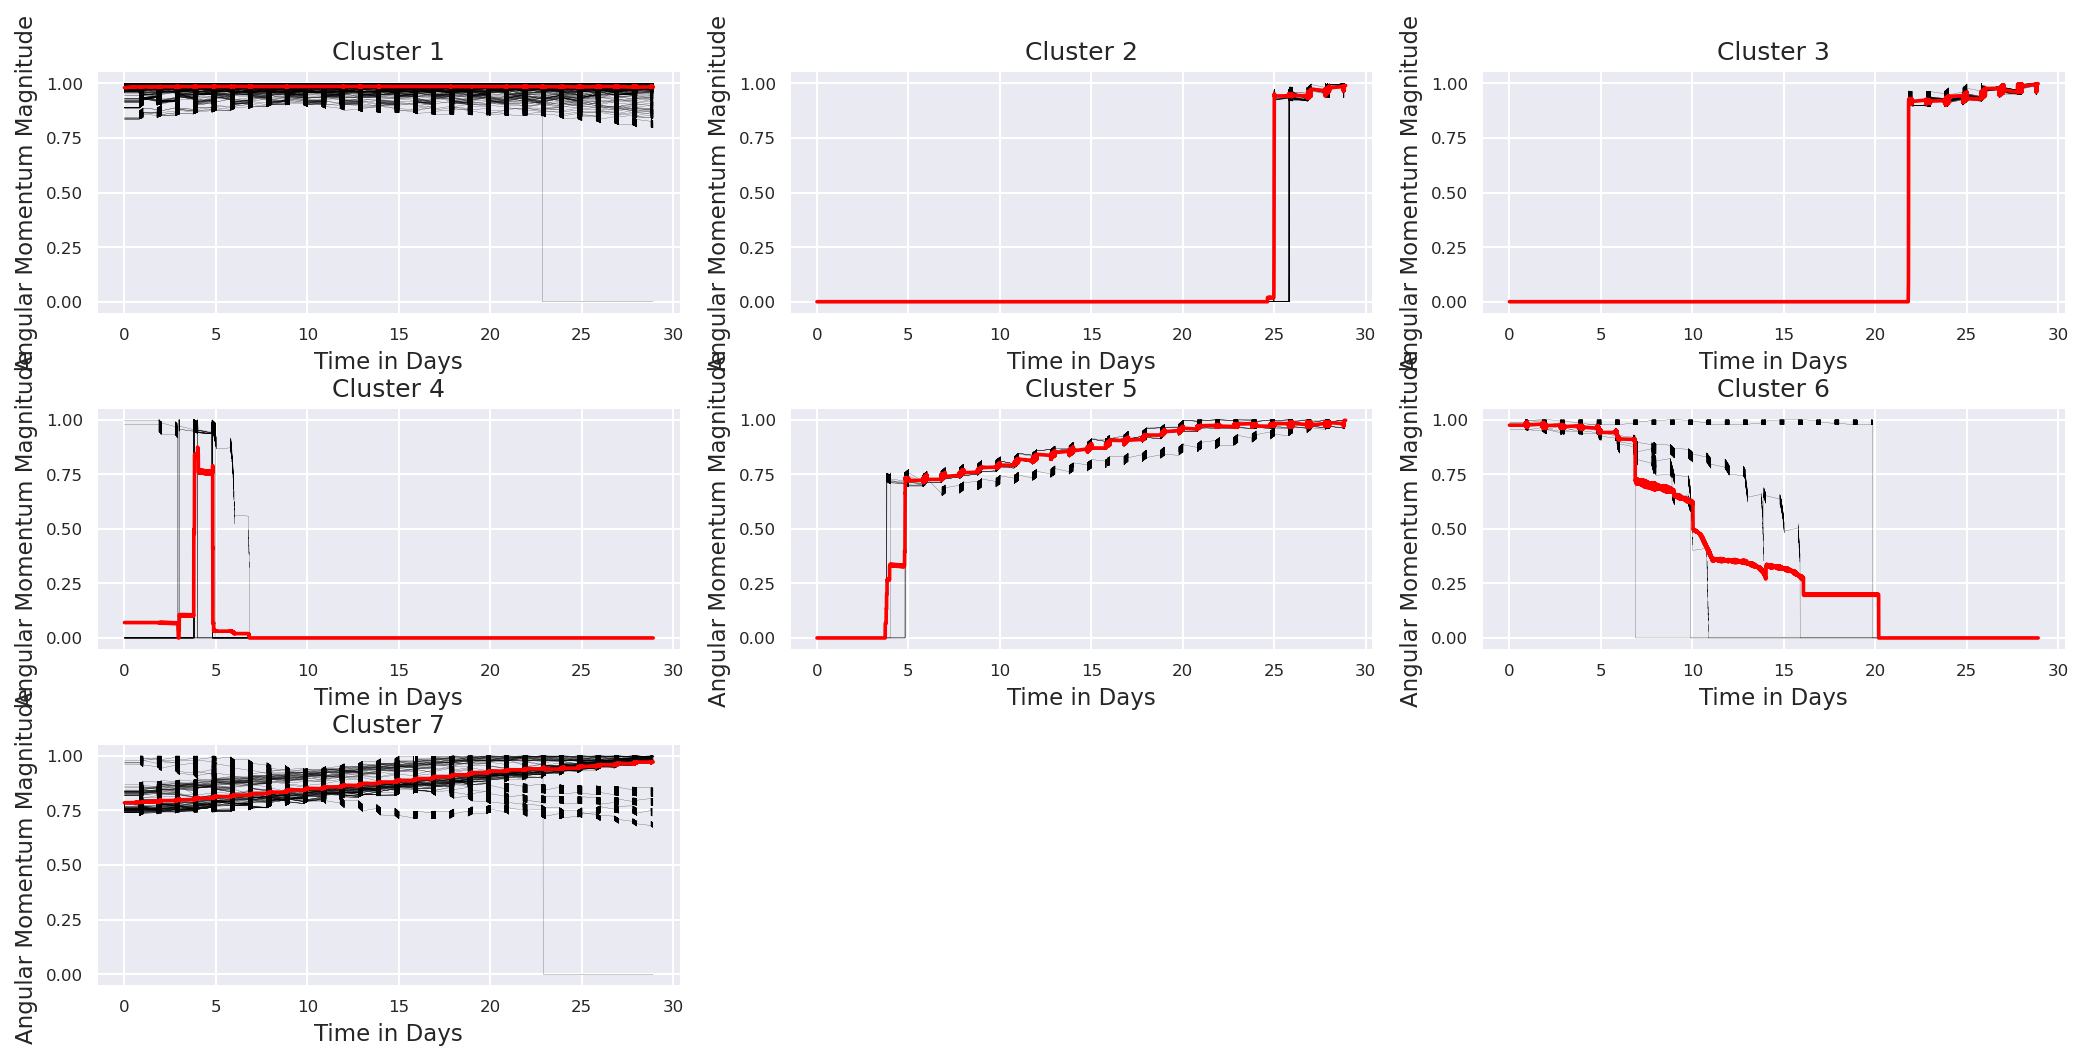

In [34]:
%matplotlib inline
plt.figure(figsize=(14, 15), dpi=150)
optimal_cluster_hmag = 7
print('Clustering on Angular momentum Magnitude')
h_clusters,h_kmeans = kmeans_optimal(time,angular_momentum_mag,optimal_cluster_hmag,1,'Angular Momentum Magnitude')
plt.ylabel('Angular Momentum Magnitude')
plt.xlabel('Time in Days')
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()


In [26]:
data_list = [angular_momentum_x, angular_momentum_y,angular_momentum_z, angular_momentum_mag,
             angular_momentum_stacked, radius]
cluster_list = [hx_clusters,hy_clusters,hz_clusters, h_clusters,h_stack_clusters,r_clusters]
cluster_list_name =[ 'Angular Momentum x', 'Angular Momentum y', 'Angular Momentum z', 'Angular Momentum Magnitude', 
                   'Angular Momentum Stacked', 'Radius']
human_cluster = np.loadtxt('labels.txt',dtype = int)S

In [39]:
silhouette_score = np.zeros(len(cluster_list))
ami= np.zeros(len(cluster_list))
for i in range(len(cluster_list)):
    kmeans_labels = cluster_list[i][human_cluster[:,0]]
    human_labels = human_cluster[:,1]
    ami[i] = metrics.adjusted_mutual_info_score(human_labels, kmeans_labels)
    silhouette_score[i] = metrics.silhouette_score(data_list[i],cluster_list[i])
    print("For " +cluster_list_name[i]+ '=', num_clusters, "The average silhouette score is:",silhouette_score[i],
         "The Adjusted Mutual Info score is:",ami[i])

For Angular Momentum x= 7 The average silhouette score is: 0.6360153871912836 The Adjusted Mutual Info score is: -0.04160892758213759
For Angular Momentum y= 7 The average silhouette score is: 0.6259217642472982 The Adjusted Mutual Info score is: -0.010251099858139536
For Angular Momentum z= 7 The average silhouette score is: 0.9810430645506223 The Adjusted Mutual Info score is: 0.2426873091234045
For Angular Momentum Magnitude= 7 The average silhouette score is: 0.8420902698853014 The Adjusted Mutual Info score is: 0.4595265454893526
For Angular Momentum Stacked= 7 The average silhouette score is: 0.6443977287734289 The Adjusted Mutual Info score is: -0.02721612428115483
For Radius= 7 The average silhouette score is: 0.8315713536330551 The Adjusted Mutual Info score is: 0.4595265454893526


In [ ]:
print(metrics.silhouette_score(angular_momentum_z,hz_clusters))

In [14]:
# Plots in 3d angular momentum vector of each satellite coloring based on cluster at a time point
fig1 = plt.figure(figsize = (10,10))
ax = fig1.add_subplot(111, projection='3d')
plot_clusters_3d(0,hz_clusters,num_clusters,angular_momentum_x,angular_momentum_y,angular_momentum_z,0)
# plot_clusters_3d(0,r_clusters,num_clusters,position[:,:,0:1],position[:,:,1:2],position[:,:,2:3],0)
plt.ion()
plt.show()

<IPython.core.display.Javascript object>

In [1]:
plt.close()
# Generates an animation for time evolution of angular momentum vector
print(time[:,::24].shape[1])
ts_fig = plt.figure(figsize = (10, 10))
ax = ts_fig.add_subplot(111, projection='3d')
anim = animation.FuncAnimation(ts_fig, 
                                plot_clusters_3d, 
                                frames=time[:,::24].shape[1], 
                                interval=20, 
                                fargs=(hz_clusters,num_clusters,angular_momentum_x[:,::24],
                                                    angular_momentum_y[:,::24],
                                                    angular_momentum_z[:,::24],0),
                                blit=True,
                                repeat_delay=200)
plt.show()

NameError: name 'plt' is not defined

In [ ]:
plt.close()
# Generates an animation for time evolution of angular momentum vector
print(time[:,::24].shape[1])
ts_fig = plt.figure(figsize = (10, 10))
ax = ts_fig.add_subplot(111, projection='3d')
anim = animation.FuncAnimation(ts_fig, 
                                plot_clusters_3d, 
                                frames=time.shape[1], 
                                interval=20, 
                                fargs=(r_clusters,num_clusters,position[:,:,0:1],
                                                    position[:,:,1:2],
                                                    position[:,:,2:3],0),
                                blit=True,
                                repeat_delay=200)
plt.show()

In [ ]:
plt.close()
# Generates an animation for time evolution of position vector
print(time[:,::24].shape[1])
ts_fig = plt.figure(figsize = (10, 10))
ax = ts_fig.add_subplot(111, projection='3d')

anim = animation.FuncAnimation(ts_fig, 
                                plot_clusters_3d, 
                                frames=time.shape[1], 
                                interval=20, 
                                fargs=(r_clusters,num_clusters,position[:,:,0:1],
                                                    position[:,:,1:2],
                                                    position[:,:,2:3],0),
                                blit=True,
                                repeat_delay=200)
plt.show()

In [1]:
for i in range(num_clusters):
    print(np.sum(hz_clusters ==i))

NameError: name 'num_clusters' is not defined

In [57]:
def plot_time_clusters(num_clusters, data,time,kmeans,ax):
    '''
    plots each cluster separately with its mean for a given 
    '''
    clusters = kmeans.labels_
    data[data ==(3*Earth_r)**2] = np.nan
    for i in range(0,num_clusters):
        title = "Cluster" + str(i)
        # calculates the mean position and time between each satellite
        radius_mean = np.nanmean(data[clusters==i,:],axis =0)
        time_mean = np.nanmean(time[clusters==i,:],axis =0)
        # scatter plots each satellites value as a function of time
        ax[i].scatter(time[clusters==i,:],data[clusters==i,:],color = "blue",s =1)
        ax[i].plot(time_mean,radius_mean,color = "red")
        ax[i].set_title(title)
        ax[i].set_ylim([np.nanmin(data[clusters==i,:])-50, np.nanmax(data[clusters==i,:])+50])

/tmp/ipykernel_3214262/1482557777.py:10: RuntimeWarning: Mean of empty slice
  radius_mean = np.nanmean(data[clusters==i,:],axis =0)


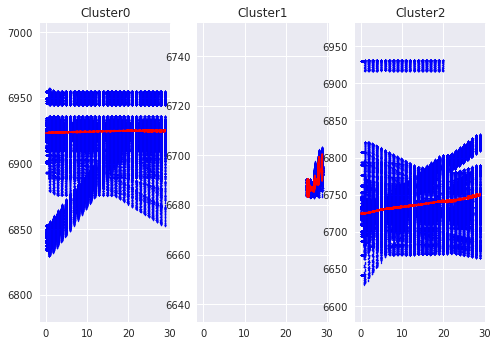

In [61]:
fig,ax = plt.subplots(nrows=1,ncols =3, sharex=True)
ax = ax.ravel()
plot_time_clusters(optimal_cluster_R, radius,time,radius_kmeans,ax)

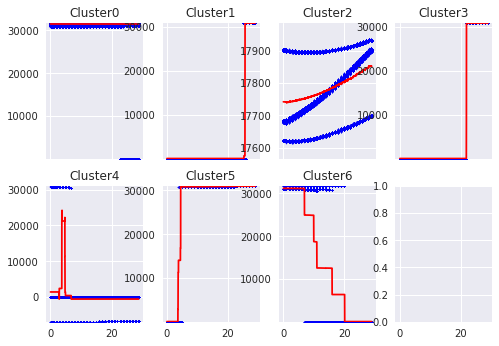

In [63]:
fig,ax = plt.subplots(nrows=2,ncols =4, sharex=True)
ax = ax.ravel()
plot_time_clusters(optimal_cluster_hz, angular_momentum_z,time,hz_kmeans,ax)

In [13]:
np.save('radius_clusters.npy',r_clusters)

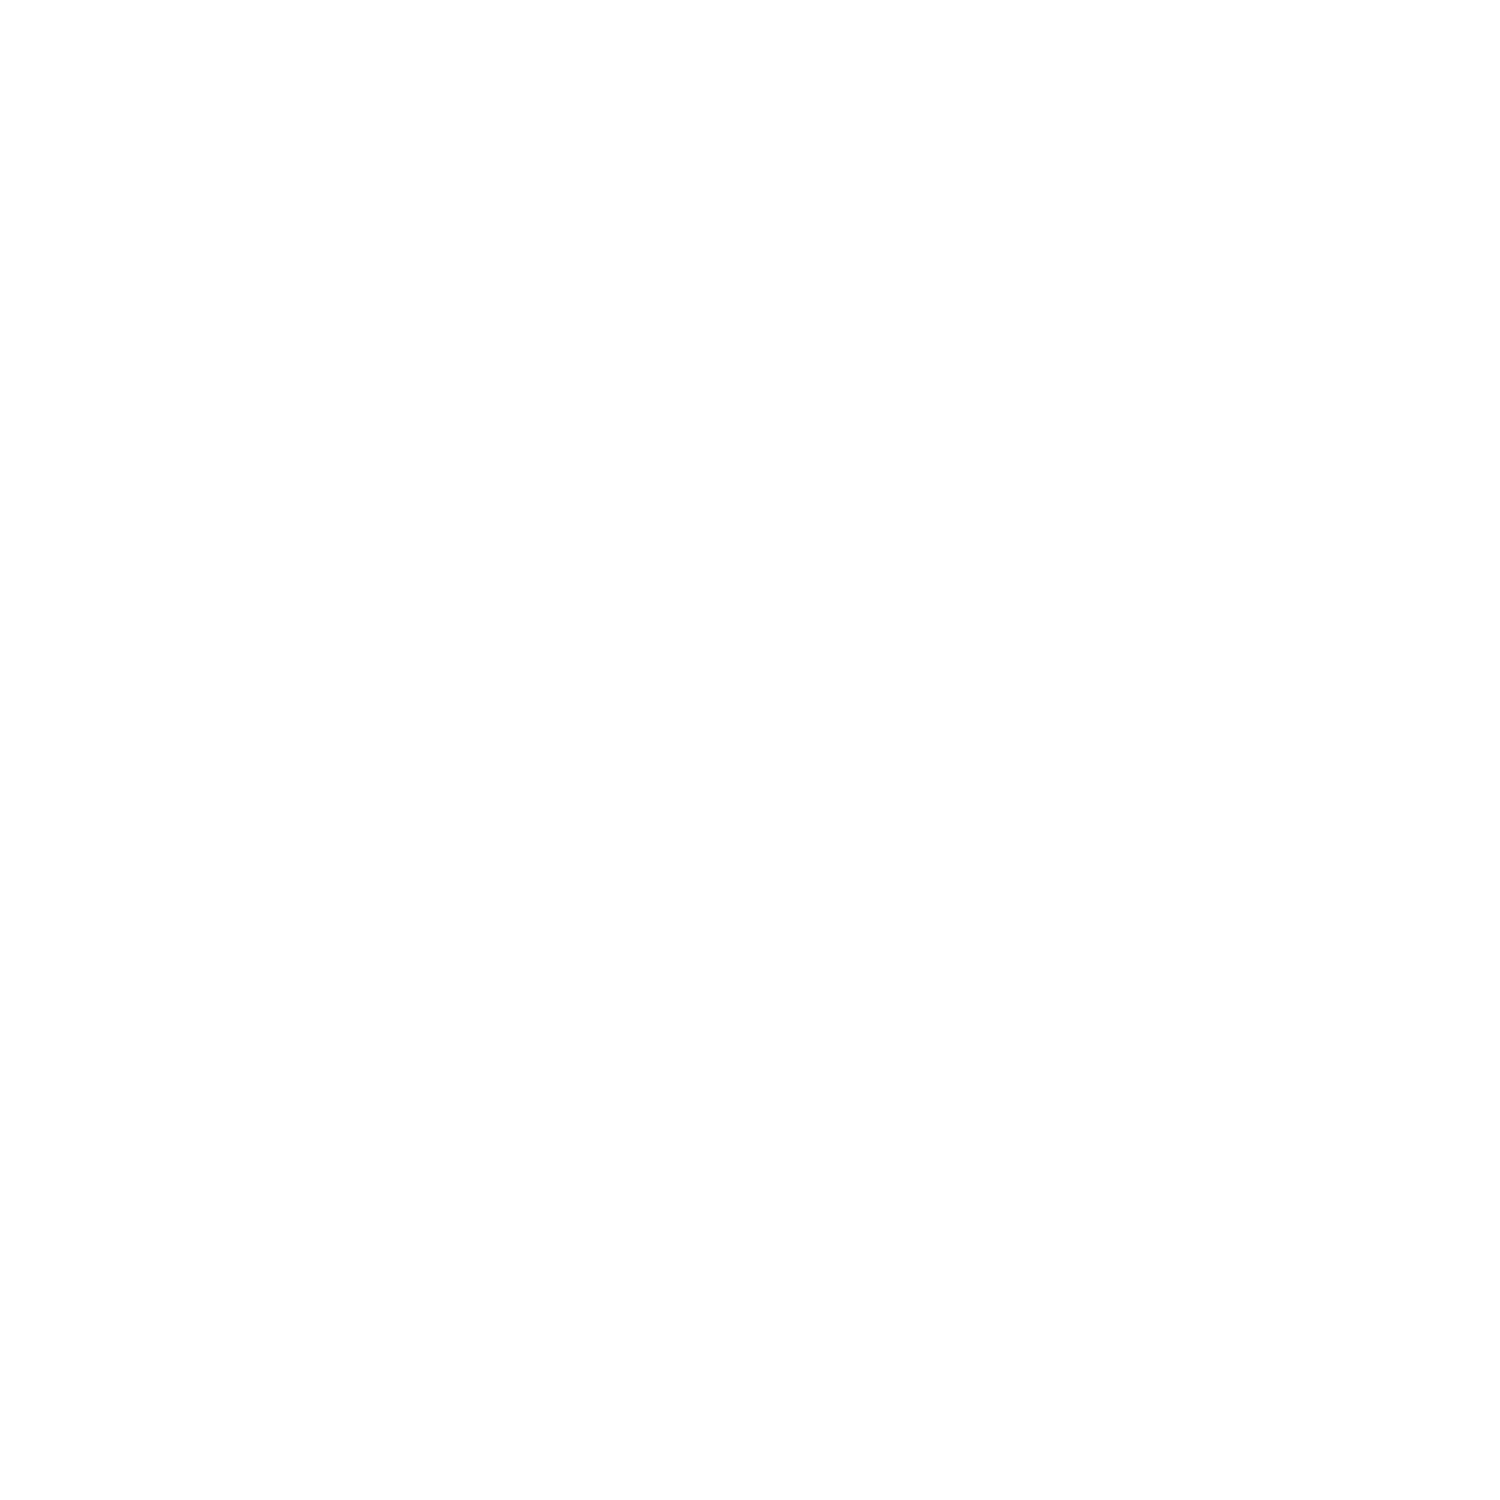

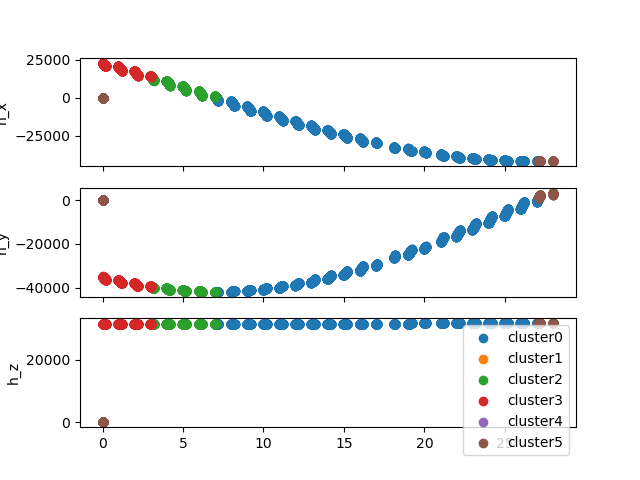

In [ ]:
radius = np.linalg.norm(starlink_data[:, :, 1:4], axis=2)
print(radius.shape)

kmeans_elbow(radius, num_cluster=20)